[Table of Contents](http://nbviewer.ipython.org/github/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/table_of_contents.ipynb)

# Nonlinear Filtering

In [1]:
#format the book
%matplotlib inline
%load_ext autoreload
%autoreload 2  
from __future__ import division, print_function
import matplotlib.pyplot as plt
import book_format
book_format.load_style()

## Introduction

The Kalman filter that we have developed to this point is extremely good, but it is also limited. All of the equations are linear, and so the filter can only handle linear problems. But the world is nonlinear, and so the classic filter that we have been studying to this point can have very limited utility.For example, the state transition function is $\mathbf{x} = \mathbf{FX}$. Suppose we wanted to track the motion of a weight on a spring. We might be tracking an automobile's active suspension, for example. The equation for the motion with $m$ being the mass, $k$ the spring constant, and $c$ the damping force is 

$$m\frac{d^2x}{dt^2} + c\frac{dx}{dt} +kx = 0$$,

which is a second order differential equation. It is not possible to write a linear equation for this equation, and therefore we cannot even formulate a design for the Kalman filter. 

The early adopters of Kalman filters needed to apply the filters to nonlinear problems and this fact was not lost on them. For example, radar is inherently nonlinear. Radars measure the slant range to an object, and we are typically interested in the aircraft's position over the ground. We invoke Pythagoras and get the nonlinear equation:

$$x=\sqrt{slant^2 - altitude^2}$$

And then, of course, the behavior of the objects being tracked is also nonlinear. So shortly after the idea of the Kalman filter was published by Kalman people began working on how to extend the Kalman filter into nonlinear problems. 

It is almost true to state that the only equation you know how to solve is $\mathbf{Ax}=\mathbf{b}$. I don't mean you the reader, but the entire mathematical community. We only really know how to do linear algebra. I can give you a linear equation and you can solve it. If I told you your job depended on knowing how to solve the equation $2x+3=4$ you would trivially solve it. If I then told you I needed to know the answer to $2x-3=8$ you would not break out into a sweat because we know all the rules for solving linear equations. I could write a program to randomly generate linear equations and you would be able to solve every one.

Any of us with a formal mathematical education spent years learning various analytic ways to solve integrals, differential equations and so on. It was all a lie, nearly. Even trivial physical systems produce equations that no one in the world know how to solve analytically. I can give you an equation that you are able to integrate, multiply or add in an $ln$ term, and render it insolvable. 

Instead of embracing that fact we spent our days studying ridiculous simplifications of problems. It is stuff like this that leads to jokes about physicists stating things like "I have the solution! Assume a spherical cow on a frictionless surface in a vacuum..."

So how do we do things like model airflow over an aircraft in a computer, or predict weather, or track missiles with a Kalman filter?  We retreat to what we know: $\mathbf{Ax}=\mathbf{b}$. We find some way to linearize the problem, turning it into a set of linear equations, and then use our linear algebra software packages to grind out a solution. It's an approximation, so the answers are approximate. Linearizing a nonlinear problem gives us inexact answers, and in a recursive algorithm like a Kalman filter or weather tracking system these small errors can sometimes reinforce each other at each step, quickly causing the algorithm to spit out nonsense. 

So what we are about to embark upon is a difficult problem. There is not one obvious, correct, mathematically optimal solution anymore. We will be using approximations, we will be introducing errors into our computations, and we will forever be battling filters that *diverge*, that is, filters whose numerical errors overwhelm the solution. 

In the remainder of this short chapter I will illustrate the specific problems the nonlinear Kalman filter faces. You can only design a filter after understanding the particular problems the nonlinearity in your problem causes. Subsequent chapters will then delve into designing and implementing different kinds of nonlinear filters.

## The Problem with Nonlinearity

As asserted in the introduction the only math you really know how to do is linear math. Equations of the form 

$$ A\mathbf{x}=\mathbf{b}$$.

That may strike you as hyperbole. After all, in this book we have integrated a polynomial to get distance from velocity and time:
 We know how to integrate a polynomial, for example, and so we are able to find the closed form equation for distance given velocity and time:

$$\int{(vt+v_0)}\,dt = \frac{a}{2}t^2+v_0t+d_0$$

That's nonlinear. But it is also a very special form. You spent a lot of time, probably at least a year, learning how to integrate various terms, and you still can not integrate some arbitrary equation - no one can. We don't know how. If you took freshman Physics you perhaps remember homework involving sliding frictionless blocks on a plane and other toy problems. At the end of the course you were almost entirely unequipped to solve real world problems because the real world is nonlinear, and you were taught linear, closed forms of equations. It made the math tractable, but mostly useless. 

The mathematics of the Kalman filter is beautiful in part due to the Gaussian equation being so special. It is nonlinear, but when we add and multiply it using linear algebra we get another Gaussian equation as a result. That is very rare. $\sin{x}*\sin{y}$ does not yield a $\sin(\cdot)$ as an output.

> If you are not well versed in signals and systems there is a perhaps startling fact that you should be aware of. A linear system is defined as a system whose output is linearly proportional to the sum of all its inputs. A consequence of this is that to be linear if the input is zero than the output must also be zero. Consider an audio amp - if I sing into a microphone, and you start talking, the output should be the sum of our voices (input) scaled by the amplifier gain. But if amplifier outputs a nonzero signal for a zero input the additive relationship no longer holds. This is because you can say $amp(roger) = amp(roger + 0)$ This clearly should give the same output, but if amp(0) is nonzero, then

> $$
\begin{aligned}
amp(roger) &= amp(roger + 0) \\
&= amp(roger) + amp(0) \\
&= amp(roger) + non\_zero\_value
\end{aligned}
$$

>which is clearly nonsense. Hence, an apparently linear equation such as
>
$$L(f(t)) = f(t) + 1$$
>
>is not linear because $L(0) = 1$! Be careful!

## An Intuitive Look at the Problem

I particularly like the following way of looking at the problem, which I am borrowing from Dan Simon's *Optimal State Estimation* [1]. Consider a tracking problem where we get the range and bearing to a target, and we want to track its position. Suppose the distance is 50 km, and the reported angle is 90$^\circ$. Now, given that sensors are imperfect, assume that the errors in both range and angle are distributed in a Gaussian manner. That is, each time we take a reading the range will be $50\pm\sigma^2_{range}$ and the angle will be $90\pm\sigma^2_{angle}$. Given an infinite number of measurements what is the expected value of the position?

I have been recommending using intuition to solve problems in this book, so let's see how it fares for this problem (hint: nonlinear problems are *not* intuitive). We might reason that since the mean of the range will be 50 km, and the mean of the angle will be 90$^\circ$, that clearly the answer will be x=0 km, y=90 km.

Well, let's plot that and find out. Here are 300 points plotted with a normal distribution of the distance of 0.4 km, and the angle having a normal distribution of 0.35 radians. We compute the average of the all of the positions, and display it as a star. Our intuition is displayed with a triangle.

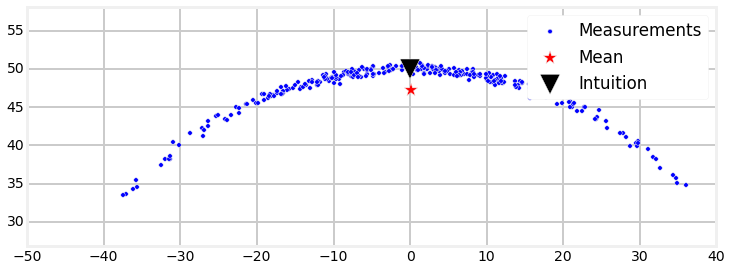

In [2]:
from numpy.random import randn
import matplotlib.pyplot as plt
import math

xs, ys = [], []
N = 300
for i in range (N):
    a = math.pi / 2. + (randn() * 0.35)
    r = 50.0         + (randn() * 0.4)
    xs.append(r*math.cos(a))
    ys.append(r*math.sin(a))

plt.scatter(xs, ys, label='Measurements')
plt.scatter(sum(xs)/N, sum(ys)/N, c='r', marker='*', s=200, label='Mean')
plt.scatter(0, 50, c='k', marker='v', s=400, label='Intuition')
plt.axis('equal')
plt.legend(scatterpoints=1)
plt.show()

We can see that out intuition failed us because the nonlinearity of the problem forced all of the errors to be biased in one direction. This bias, over many iterations, can cause the Kalman filter to diverge. But this chart should now inform your intuition for the rest of the book - linear approximations applied to nonlinear problems yields inaccurate results.

## The Effect of Nonlinear Functions on Gaussians

Unfortunately Gaussians are not closed under an arbitrary nonlinear function. Recall the equations of the Kalman filter - at each step of its evolution we do things like pass the covariances through our process function to get the new covariance at time $k$. Our process function was always linear, so the output was always another Gaussian.  Let's look at that on a graph. I will take an arbitrary Gaussian and pass it through the function $f(x) = 2x + 1$ and plot the result. We know how to do this analytically, but lets do this with sampling. I will generate 500,000 points on the Gaussian curve, pass it through the function, and then plot the results. I will do it this way because the next example will be nonlinear, and we will have no way to compute this analytically.

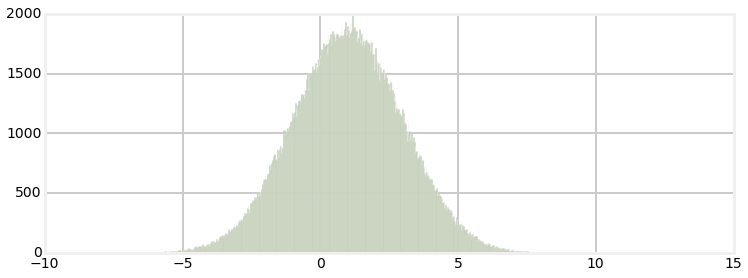

In [3]:
import numpy as np
from numpy.random import normal

gaussian = (0.0, 1.0)
data = normal(loc=gaussian[0], scale=gaussian[1], size=500000)
ys = 2*data + 1

plt.hist(ys, 1000)
plt.show()

This is an unsurprising result. The result of passing the Gaussian through $f(x)=2x+1$ is another Gaussian centered around 1. Let's look at the input, nonlinear function, and output at once.

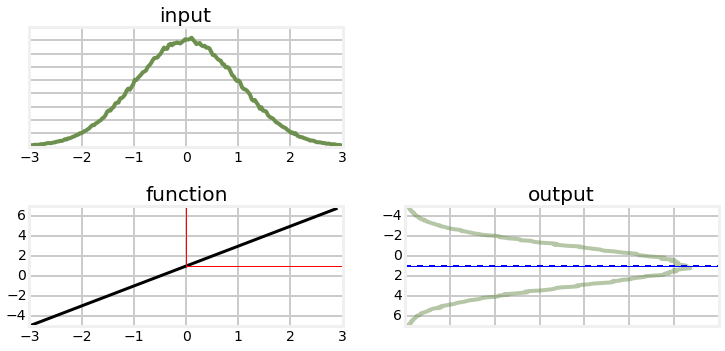

In [4]:
from nonlinear_plots import plot_nonlinear_func

def g1(x):
    return 2*x+1

with book_format.figsize(y=5):
    plot_nonlinear_func(data, g1, gaussian)

> I explain how to plot Gaussians, and much more, in the Notebook *Computing_and_Plotting_PDFs* in the 
Supporting_Notebooks folder. You can also read it online [here](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/Supporting_Notebooks/Computing_and_plotting_PDFs.ipynb)[1]

The plot labeled 'input' is the histogram of the original data. This is passed through the transfer function $f(x)=2x+1$ which is displayed in the chart on the bottom lweft
. The red lines shows how one value, $x=0$ is passed through the function. Each value from input is passed through in the same way to the output function on the left. For the output I computed the mean by taking the average of all the points, and drew the results with the dotted blue line. A solid blue line shows the actual mean for the point $x=0$. The output looks like a Gaussian, and is in fact a Gaussian. We can see that it is altered -the variance in the output is larger than the variance in the input, and the mean has been shifted from 0 to 1, which is what we would expect given the transfer function $f(x)=2x+1$ The $2x$ affects the variance, and the $+1$ shifts the mean The computed mean, represented by the dotted blue line, is nearly equal to the actual mean. If we used more points in our computation we could get arbitrarily close to the actual value.

Now let's look at a nonlinear function and see how it affects the probability distribution.

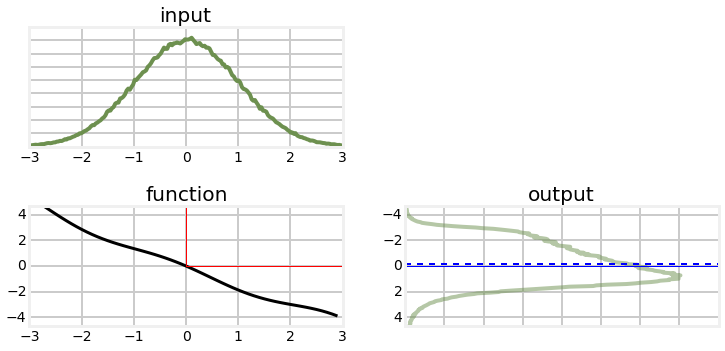

In [5]:
def g2(x):
    return (np.cos(3*(x/2 + 0.7))) * np.sin(0.3*x) - 1.6*x

with book_format.figsize(y=5):
    plot_nonlinear_func(data, g2, gaussian)

This result may be somewhat surprising to you. The function looks "fairly" linear - it is pretty close to a straight line, but the probability distribution of the output is completely different from a Gaussian.  Recall the equations for multiplying two univariate Gaussians:

$$\begin{aligned}
\mu =\frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}\mbox{, } 
\sigma = \frac{1}{\frac{1}{\sigma_1^2} + \frac{1}{\sigma_2^2}}
\end{aligned}$$

These equations do not hold for non-Gaussians, and certainly do not hold for the probability distribution shown in the 'output' chart above. 

Think of what this implies for the Kalman filter algorithm of the previous chapter. All of the equations assume that a Gaussian passed through the process function results in another Gaussian. If this is not true then all of the assumptions and guarantees of the Kalman filter do not hold. Let's look at what happens when we pass the output back through the function again, simulating the next step time step of the Kalman filter.

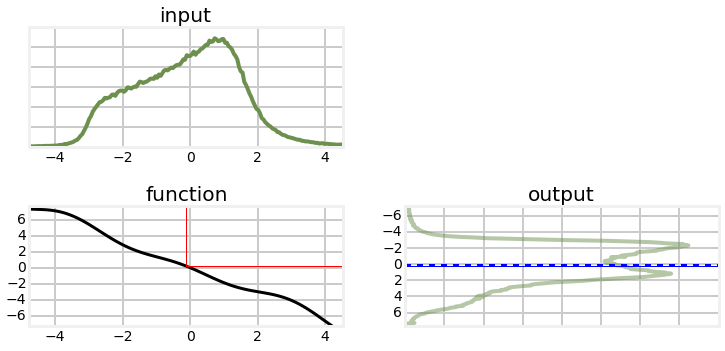

In [6]:
y = g2(data)
gaussian2 = (np.mean(y), np.var(y))
with book_format.figsize(y=5):
    plot_nonlinear_func(y, g2, gaussian2)

As you can see the probability function is further distorted from the original Gaussian. However, the graph is still somewhat symmetric around x=0, let's see what the mean is.

In [7]:
print('input  mean, variance: %.4f, %.4f'% (np.average(data), np.std(data)**2))
print('output mean, variance: %.4f, %.4f'% (np.average(y), np.std(y)**2))

input  mean, variance: -0.0017, 0.9984
output mean, variance: -0.1220, 2.4009


Let's compare that to the linear function that passes through (-2,3) and (2,-3), which is very close to the nonlinear function we have plotted. Using the equation of a line we have

$$m=\frac{-3-3}{2-(-2)}=-1.5$$

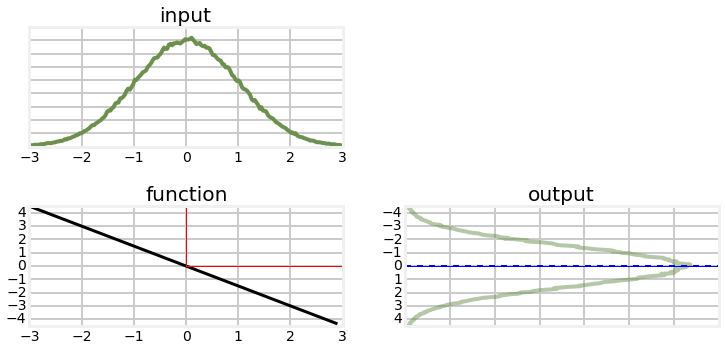

output mean, variance: 0.0025, 2.2465


In [8]:
def g3(x): 
    return -1.5 * x

with book_format.figsize(y=5):
    plot_nonlinear_func(data, g3, gaussian)
out = g3(data)
print ('output mean, variance: %.4f, %.4f'% (np.average(out), np.std(out)**2))

Although the shapes of the output are very different, the mean and variance of each are almost the same. This may lead us to reasoning that perhaps we can ignore this problem if the nonlinear equation is 'close to' linear. To test that, we can iterate several times and then compare the results.

In [9]:
out = g3(data)
out2 = g2(data)

for i in range(10):
    out = g3(out)
    out2 = g2(out2)
print('linear    output mean, variance: %.4f, %.4f' % 
      (np.average(out), np.std(out)**2))
print('nonlinear output mean, variance: %.4f, %.4f' % 
      (np.average(out2), np.std(out2)**2))

linear    output mean, variance: 0.1453, 7470.2044
nonlinear output mean, variance: -8.8565, 30504.9480


Unfortunately we can see that the nonlinear version is not stable. We have drifted significantly from the mean of 0, and the variance is half an order of magnitude larger.

And, of course, we have minimized the issue by using a function that is quite close to a straight line. What happens if our function is $y(x)=x^2$?

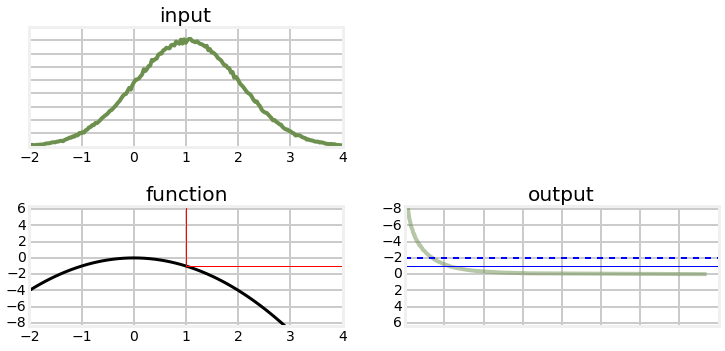

In [10]:
def g3(x): 
    return -x*x
x0 = (1, 1)
data = normal(loc=x0[0], scale=x0[1], size=500000)

with book_format.figsize(y=5):
    plot_nonlinear_func(data, g3, gaussian=x0)

Despite the curve being quite smooth and reasonably straight at $x=1$ the probability distribution of the output doesn't look anything like a Gaussian and the computed mean of the output is quite different than the value computed directly. This is not an unusual function - a ballistic object moves in a parabola, and this is the sort of nonlinearity your filter will need to handle. If you recall we tried to track a ball in the previous chapter and failed miserably. This graph should give you insight into why the filter performed so poorly.

## A 2D Example

It is somewhat hard for me to look at probability distributions like this and really reason about what will happen in a real world filter. So let's think about tracking an aircraft with radar. The aircraft may have a covariance that looks like this:

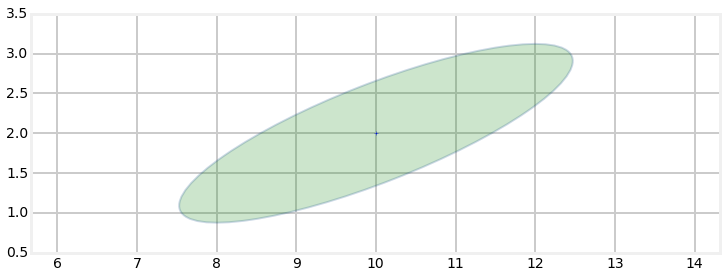

In [11]:
import filterpy.stats as stats
P = np.array([[6, 2.5], [2.5, .6]])
stats.plot_covariance_ellipse((10, 2), P, facecolor='g', alpha=0.2)

So what happens when we try to linearize this problem? The radar gives us a range to the aircraft. Suppose the radar is directly under the aircraft (x=10) and the next measurement states that the aircraft is 3 miles away (y=3). The positions that could match that measurement form a circle with radius 3 miles, like so.

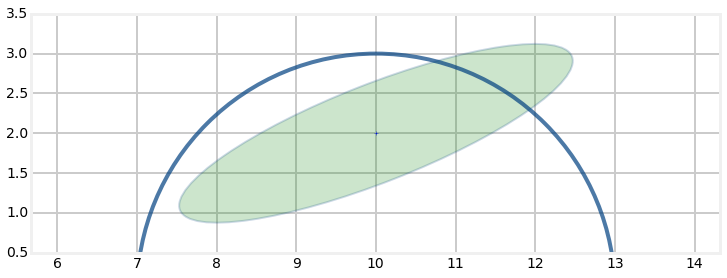

In [12]:
from matplotlib.patches import Ellipse
circle1=plt.Circle((10,0),3,color='#004080',fill=False,linewidth=4, alpha=.7)
ax = plt.gca()
ax.add_artist(circle1)
plt.xlim(0,10)
plt.ylim(0,3)

stats.plot_covariance_ellipse((10, 2), P, facecolor='g', alpha=0.2)

We can see by inspection that the probable position of the aircraft is somewhere near x=11.4, y=2.7 because that is where the covariance ellipse and range measurement overlap. But the range measurement is nonlinear so we have to linearize it. We haven't covered this material yet, but the EKF will linearize at the last position of the aircraft - (10,2). At x=10 the range measurement has y=3, and so we linearize at that point.

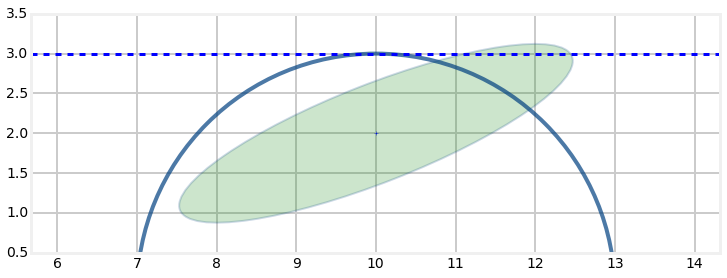

In [13]:
from matplotlib.patches import Ellipse
circle1=plt.Circle((10,0),3,color='#004080',fill=False,linewidth=4, alpha=.7)
ax = plt.gca()
ax.add_artist(circle1)
plt.xlim(0,10)
plt.ylim(0,3)
plt.axhline(3, ls='--')
stats.plot_covariance_ellipse((10, 2), P,  facecolor='g', alpha=0.2)

Now we have a linear representation of the problem (literally a straight line) which we can solve. Unfortunately you can see that the intersection of the line and the covariance ellipse is a long way from the actual aircraft position.

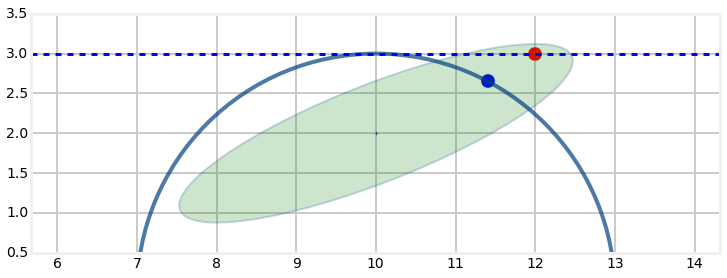

In [14]:
from matplotlib.patches import Ellipse
circle1=plt.Circle((10,0),3,color='#004080',fill=False,linewidth=4, alpha=.7)
ax = plt.gca()
ax.add_artist(circle1)
plt.xlim(0,10)
plt.ylim(0,3)
plt.axhline(3, ls='--')
stats.plot_covariance_ellipse((10, 2), P,  facecolor='g', alpha=0.2)
plt.scatter([11.4], [2.65],s=200)
plt.scatter([12], [3], c='r', s=200)
plt.show()

That sort of error often leads to disastrous results. The error in this estimate is large. But in the next innovation of the filter that very bad estimate will be used to linearize the next radar measurement, so the next estimate is likely to be markedly worse than this one. After only a few iterations the Kalman filter will diverge, and start producing results that have no correspondence to reality.

Of course that is a rather large covariance ellipse for an aircraft - it spans miles. I exaggerated the size to illustrate the difficulties of highly nonlinear systems. In real radar tracking problems the nonlinearity is usually not that bad, but the errors can still accumulate. And other systems you may be working with do have this amount of nonlinearity - this was not an exaggeration to make a point. You will always be battling divergence when working with nonlinear systems.

## The Algorithms

You may be impatient to solve a specific problem, and wondering which filter to use. So let me quickly run through the options. The subsequent chapters are somewhat independent of each other, and you can fruitfully skip around, though I recommend reading linearly if you truly want to master all of the material. 

The workhorses of nonlinear filters are the *linearized Kalman filter* and *extended Kalman filter*. These two techniques were invented shortly after Kalman published his paper and they have been the main techniques used since then. The flight software in airplanes, the GPS in your car or phone almost certainly use one of these techniques. 

However, these techniques are extremely demanding. The EKF linearizes the differential equations at one point, which requires you to find a solution to a matrix of partial derivatives (a Jacobian). This can be difficult or impossible to do analytically. If impossible, you have to use numerical techniques to find the Jacobian, but this is expensive computationally and introduces error into the system. Finally, if the problem is quite nonlinear the linearization leads to a lot of error being introduced in each step, and the filters frequently diverge. You can not throw some equations into some arbitrary solver and expect to to get good results. It's a difficult field for professionals. I note that most Kalman filtering textbooks merely gloss over the extended Kalman filter (EKF) despite it being the most frequently used technique in real world applications. 

Recently the field has been changing in exciting ways. First, computing power has grown to the point that we can use techniques that were once beyond the ability of a supercomputer. These use *Monte Carlo* techniques - the computer generates thousands to tens of thousands of random points and tests all of them against the measurements. It then probabilistically kills or duplicates points based on how well they match the measurements. A point far away from the measurement is unlikely to be retained, whereas a point very close is quite likely to be retained. After a few iterations there is a clump of particles closely tracking your object, and a sparse cloud of points where there is no object.

This has two benefits. First, there is no process model. You do not need to predict your system state in the next time step. This is of huge value if you do not have a good model for the behavior of the system. For example, it is hard to predict the behavior of a person in a crowd for very long. You don't know where they are going, and they are endlessly being diverted and jostled by the crowd. Second, the algorithm can track arbitrarily many objects at once - some particles will match the behavior on one object, and other particles will match other objects. So this technique is often used to track automobile traffic, people in crowds, and so on. 

The costs should be clear. It is computationally expensive to test tens of thousands of points for every step in the filter. But modern CPUs are very fast, and this is a perfect problem for GPUs because the algorithm is highly parallelizable. If we do have the ability to use a process model that is important information that is just being ignored by the filter - you rarely get better results by ignoring information. Of course, there are hybrid filters that do use a process model. Then, the answer is not mathematical. With a Kalman filter my covariance matrix gives me important information about the amount of error in the estimate. The particle filter does not give me a rigorous way to compute this. Finally, the output of the filter is a cloud of points; I then have to figure out how to interpret it. Usually you will be doing something like taking the mean of the points, but this is a difficult problem. There are still many points that do not 'belong' to a tracked object, so you first have to run some sort of clustering algorithm to first find the points that seem to be tracking an object, and then you need another algorithm to produce an state estimate from those points. None of this is intractable, but it is all quite computationally expensive. 


Finally, we have a new algorithm called the *unscented Kalman filter* (UKF) that does not require you to find analytic solutions to nonlinear equations, and yet almost always performs better than the EKF. It does especially well with highly nonlinear problems - problems where the EKF has significant difficulties. Designing the filter is extremely easy. Some will say the jury is still out, but to my mind the UKF is superior in almost every way to the EKF, and should be the starting point for any implementation, especially if you are not a Kalman filter professional with a graduate degree in the relevant mathematical techniques. The main downside is that the UKF can be a few times slower than the EKF, but this really depends on whether the EKF solves the Jacobian analytically or numerically. If numerically the UKF is almost certainly faster. Finally, it has not been proven (and probably it cannot be proven) that the UKF always yields more accurate results than the EKF. In practice it almost always does, often significantly so. It is very easy to understand and implement, and I strongly suggest this technique as your starting point. 

## Summary

The world is nonlinear, but we only really know how to solve linear problems. This introduces significant difficulties for Kalman filters. We've looked at how nonlinearity affects filtering in 3 different but equivalent ways, and I've given you a brief summary of the major appoaches: the linearized Kalman filter, the extended Kalman filter, the Unscented Kalman filter, and the particle filter. 

Until recently the linearized Kalman filter and EKF have been the standard way to solve these problems. They are very difficult to understand and use, and they are also potentially very unstable. 

Recent developments have offered what are to my mind superior approaches. The UKF dispenses with the need to find solutions to partial differential equations, but it is usually more accurate than the EKF. It is easy to use and understand. I can get a basic UKF going in just a few minutes by using FilterPy. The particle filter dispenses with mathimatical modeling completely in favor of a Monte Carlo technique of generating a random cloud of thousands of points. It runs slowly, but it can solve otherwise intractable problems with relative ease.

I get more email about the EKF than anything else; I suspect that this is because most treatments in books, papers, and on the internet use the EKF. If your interest is in mastering the field of course you will want to learn about the EKF. But if you are just trying to get good results I point you to the UKF and particle filter first. They are so much easier to implement, understand, and use, and they are typically far more stable than the EKF. 

Some will quibble with that advice. A lot of recent publications are devoted to a comparison of the EKF, UKF, and perhaps a few other choices for a given problem. Do you not need to perform a similar comparison for your problem? If you are sending a rocket to Mars, then of course you do. You will be balancing issues such as accuracy, round off errors, divergence, mathematical proof of correctness, and the computational effort required. I can't imagine not knowing the EKF intimately. 

On the other hand the UKF works spectacularly! I use it at work for real world applications. I mostly haven't even tried to implement an EKF for these applications because I can verify that the UKF is working fine. Is it possible that I might eke out another 0.2% of performance from the EKF in certain situations? Sure! Do I care? No! I completely understand the UKF implementation, it is easy to test and verify, I can pass the code to others and be confident that they can understand and modify it, and I am not a masochist that wants to battle difficult equations when I already have a working solution. If the UKF or particle filters start to perform poorly for some problem then I will turn other techniques, but not before then. And realistically, the UKF usually provides substantially better performance than the EKF over a wide range of problems and conditions. If "really good" is good enough I'm going to spend my time working on other problems. 

I'm belaboring this point because in most textbooks the EKF is given center stage, and the UKF is either not mentioned at all or just given a 2 page gloss that leaves you completely unprepared to use the filter. This is not due to ignorance on the writer's part. The UKF is still relatively new, and it takes time to write new editions of books. At the time many books were written the UKF was either not discovered yet, or it was just an unproven but promising curiosity. But I am writing this now, the UKF has had enormous success, and it needs to be in your toolkit. That is what I will spend most of my effort trying to teach you. 

## References

[1] https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/Supporting_Notebooks/Computing_and_plotting_PDFs.ipynb